In [ ]:
pip install awswrangler

In [2]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the GoogleDrive object
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
import pandas as pd

In [19]:

import pandas as pd

def load_data(filepath):
    """Carga los datos desde un archivo CSV."""
    df = pd.read_csv(filepath)
    print(f"Shape of the data: {df.shape}")
    return df


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

def prepare_data(df, numeric_features, categorical_features, target_column):
    """Prepares the data by cleaning and feature engineering."""
    # Impute initial missing values for 'RainToday' and 'RainTomorrow'
    df['RainToday'].fillna('No', inplace=True)
    df['RainTomorrow'].fillna('No', inplace=True)

    # Creating the _Location_type categorical feature early in the process
    if 'Location' in df.columns and 'Rainfall' in df.columns:
        wet_mean = df[['Location', 'Rainfall']].groupby('Location').mean().mean().values[0]
        wet_cities_mean = df[['Location', 'Rainfall']].groupby('Location').mean()
        wet_cities_mean = wet_cities_mean[wet_cities_mean['Rainfall'] > wet_mean].index
        df['_Location_type'] = df['Location'].apply(lambda x: 'Wet Location' if x in wet_cities_mean else 'Dry Location')
    else:
        df['_Location_type'] = 'Unknown'  # Default value if 'Location' or 'Rainfall' is missing

    # Identify columns with null values
    null_counts = df.isnull().sum()

    # Remove columns with high percentage of missing values
    irrelevant_columns = [col for col in df.columns if (null_counts[col] / len(df)) > 0.5]
    df = df.drop(irrelevant_columns, axis=1)

    # Impute missing values for numeric features
    numeric_imputer = SimpleImputer(strategy='mean')
    df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])

    # Impute missing values for categorical features
    df[categorical_features] = df[categorical_features].fillna('Unknown')

    # Filter data based on a specific date
    if 'Date' in df.columns:
        df = df[df['Date'] > '2013-01-01']

    # Visualize initial data
    target_columns = ['RainToday', 'RainTomorrow']
    for target in target_columns:
        sns.boxplot(data=df, x=target, y='Rainfall', flierprops={"marker": "x"}, medianprops={"color": "red", "linewidth": 2})
        plt.title(f"Boxplot of Rainfall when {target}")
        plt.show()

        sns.kdeplot(data=df[df[target] == 'Yes'], x='Rainfall', color='green', fill=True)
        plt.title(f"Density Plot of Rainfall when {target}")
        plt.show()

    # Handle outliers in 'Rainfall'
    if 'Rainfall' in df.columns:
        q1 = df['Rainfall'].quantile(0.25)
        q3 = df['Rainfall'].quantile(0.75)
        iqr = q3 - q1
        df = df[~((df['Rainfall'] > (q3 + 1.5 * iqr)) | (df['Rainfall'] < (q1 - 1.5 * iqr)))]

    # Add a month column if 'Date' is available
    if 'Date' in df.columns:
        df['_Month'] = pd.to_datetime(df['Date']).dt.month

    # Select specific columns
    selected_columns = numeric_features + categorical_features + [target_column]
    df = df[selected_columns]

    # Save the resulting DataFrame to a CSV file
    df.to_csv('prepared_data.csv', index=False)

    return df

# Example usage:
# Make sure your 'data' DataFrame is defined and loaded with the necessary columns
# prepared_data = prepare_data(data, numeric_features, categorical_features, target_column)
# print(prepared_data.head())



In [43]:
import awswrangler as wr

In [45]:
df_rain =  wr.s3.read_csv("s3://data/data_info/weatherAUS.csv")
print(df_rain.shape)
df_rain.head()

NoCredentialsError: Unable to locate credentials

In [33]:
file_path = 's3://data/data_info/weatherAUS.csv'
data = load_data(file_path)

Shape of the data: (145460, 23)


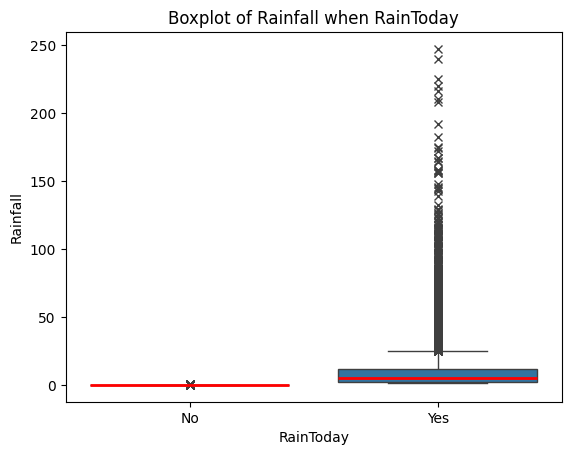

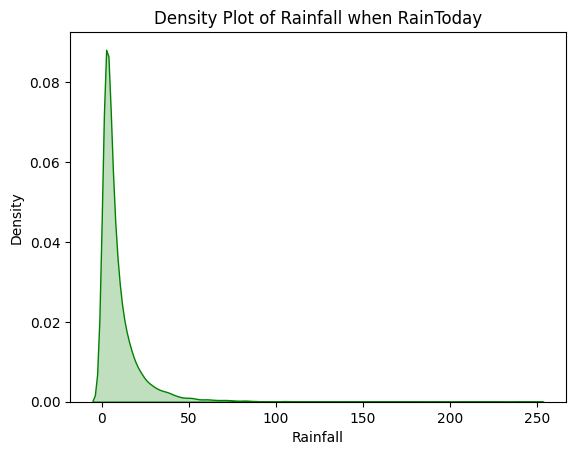

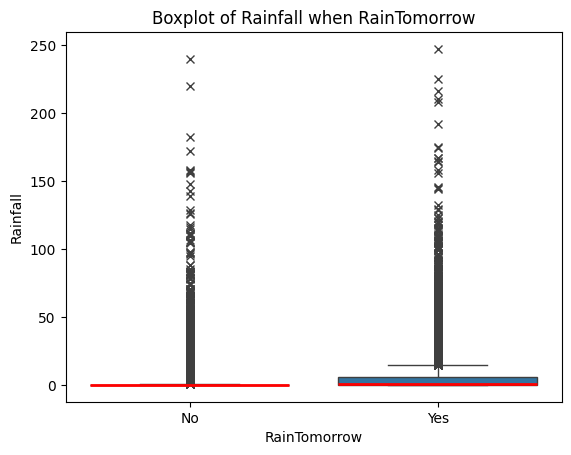

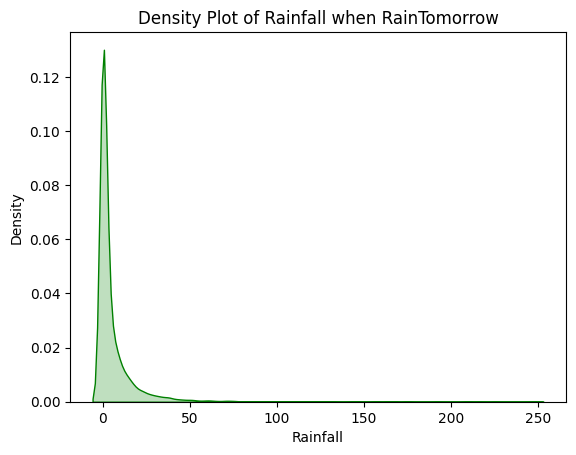

      Sunshine  Humidity9am  Humidity3pm  Cloud9am  Cloud3pm _Location_type  \
1432  7.611178         48.0         17.0  4.447461   4.50993   Dry Location   
1433  7.611178         32.0         20.0  4.447461   4.50993   Dry Location   
1434  7.611178         44.0         12.0  4.447461   4.50993   Dry Location   
1435  7.611178         36.0         17.0  4.447461   1.00000   Dry Location   
1437  7.611178         47.0         22.0  4.447461   4.50993   Dry Location   

     RainTomorrow  
1432           No  
1433           No  
1434           No  
1435          Yes  
1437           No  


In [40]:
import pandas as pd

# Definir las características numéricas, categóricas y la columna objetivo
numeric_features = ['Sunshine', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm']
categorical_features = ['_Location_type']
target_column = 'RainTomorrow'

# Llamar a la función prepare_data con las características definidas
prepared_data = prepare_data(data, numeric_features, categorical_features, target_column)

print(prepared_data.head())
